In [ ]:
import pandas as pd
import numpy as np
import requests

import folium

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


In [ ]:
CLIENT_ID = '3D0SPLK3KXYXMJNBTTTML0WAFJF5BZC0UKTQF25XDNUW34LO' # Foursquare ID
CLIENT_SECRET ='ZC4J1KAIR5D1YWHXLM2FYV5TDUDFJIF1LIXO2XWX3BIRAU0Z' # Foursquare Secret
VERSION = '20180604'

In [3]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [4]:
df_ny = get_new_york_data()

In [5]:
df_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
df_ny.shape

(306, 4)

Analysing restaurants in the neighborhood

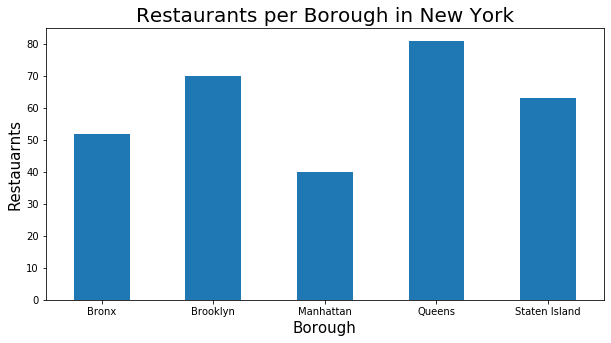

In [65]:
df_ny.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5))
plt.title('Restaurants per Borough in New York', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Restauarnts',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [8]:
def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [21]:
def get_venues(lat,lng):
    
    radius=1000
    LIMIT=100
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
        
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Lets prepare neighorhood list of Indian Restuarants in NYC

In [13]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)

print('Indian restaurants in\n---------------------')
       
for row in df_ny.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']
    if len(indian_resturants) > 0:
        print(Neighborhood+', '+Borough+' : '+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)

print('Completed constructing the Indian cuisine restaurants data set')

Indian restaurants in
---------------------
Woodlawn, Bronx : 1
Parkchester, Bronx : 1
Spuyten Duyvil, Bronx : 1
Concourse, Bronx : 1
Unionport, Bronx : 1
Bay Ridge, Brooklyn : 2
Brighton Beach, Brooklyn : 1
Flatbush, Brooklyn : 2
East Flatbush, Brooklyn : 1
Kensington, Brooklyn : 2
Prospect Heights, Brooklyn : 1
Fort Greene, Brooklyn : 1
Borough Park, Brooklyn : 1
Clinton Hill, Brooklyn : 1
Downtown, Brooklyn : 1
Prospect Lefferts Gardens, Brooklyn : 1
Ocean Hill, Brooklyn : 2
Prospect Park South, Brooklyn : 2
South Side, Brooklyn : 1
Fort Hamilton, Brooklyn : 1
Washington Heights, Manhattan : 1
Hamilton Heights, Manhattan : 2
Manhattanville, Manhattan : 2
Central Harlem, Manhattan : 2
East Harlem, Manhattan : 1
Yorkville, Manhattan : 2
Roosevelt Island, Manhattan : 1
Upper West Side, Manhattan : 1
Midtown, Manhattan : 2
Murray Hill, Manhattan : 1
Tribeca, Manhattan : 1
West Village, Manhattan : 1
Manhattan Valley, Manhattan : 3
Morningside Heights, Manhattan : 1
Gramercy, Manhattan :

In [14]:
indian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
142,Brooklyn,Broadway Junction,5539753f498edbace4746b67,Tandoori Masala
143,Brooklyn,Erasmus,564d283d498e6e851df79d87,Great Indian Curry
144,Queens,Queensbridge,50a287a7e4b0033f830f06db,Raj's Indian Kitchen
145,Queens,Queensbridge,4b1b341bf964a5208af923e3,Five Star Banquet
146,Staten Island,Fox Hills,4b65f2e3f964a5206e0a2be3,Al-Humza


Analysing how many Indian restaurants are there in the neighbourhood

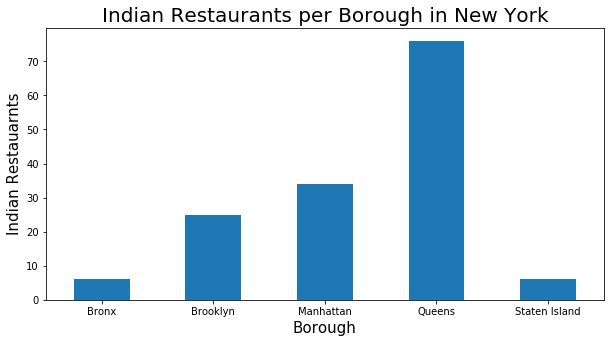

In [17]:
indian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5))
plt.title('Indian Restaurants per Borough in New York', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Indian Restauarnts',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

As per the observations from the graph, it can be found that Queens has highest number of Indian Restuarants

Lets analyse Top 10 neighborhoods based on the number of Indian cuisine restaurants in New York city.

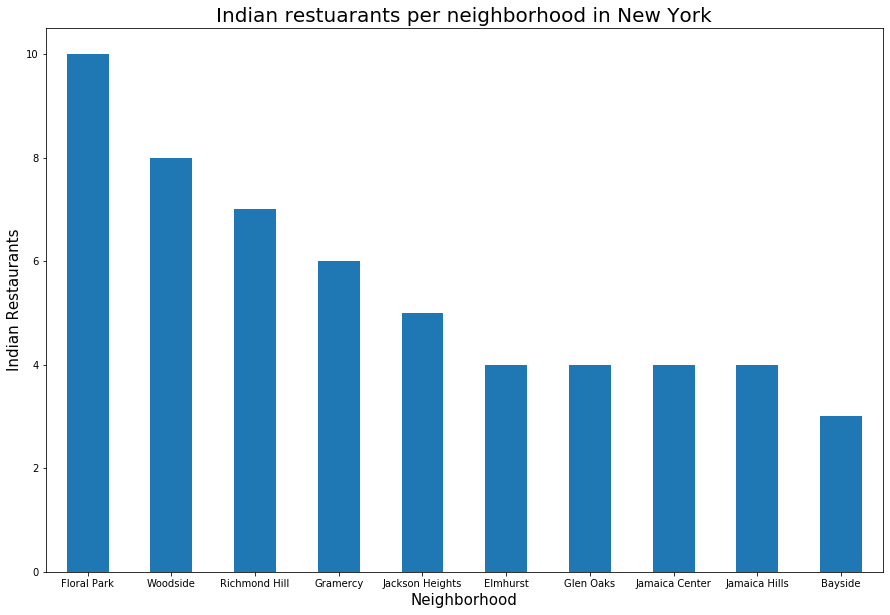

In [66]:
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot.bar(figsize=(15,10)) #top 10 restauarants 
plt.title('Indian restuarants per neighborhood in New York', fontsize = 20)
plt.xlabel('Neighborhood',fontsize = 15)
plt.ylabel('Indian Restaurants',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [19]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
102,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
103,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
104,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
105,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
106,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
107,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
108,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
109,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
110,Queens,Floral Park,4ec1b54f4690d2338a359d66,Tabaq Kebab Grill
111,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [22]:
# preparing neighborhood list of indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1

for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.8    10
( 1 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 147 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 3 / 147 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     3
( 4 / 147 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 147 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.0    26
( 6 / 147 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [23]:
convert_types = { 'Likes': float, 'Tips': float }
indian_rest_stats_ny = indian_rest_stats_ny.astype(convert_types)
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [24]:
#Restauranats with most tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.3
Tips                                 164
Name: 48, dtype: object

In [25]:
#Restauarants with max likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               8.6
Tips                                 148
Name: 40, dtype: object

In [27]:
#Restauarants with max ratings
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              57596dad498e732300496b23
Name                         Dosa Royale
Likes                                 76
Rating                               8.8
Tips                                  22
Name: 14, dtype: object

### Create list of top 10 neighborhood in order of their average rating of restaurants

In [47]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [48]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
4,Clinton Hill,8.800
10,Fort Greene,8.800
32,West Village,8.700
22,Prospect Heights,8.700
23,Prospect Lefferts Gardens,8.700
28,Tribeca,8.600
19,Murray Hill,8.600
25,Roosevelt Island,8.500
30,Upper West Side,8.500
12,Gramercy,8.475


### Average rating of Indian Resturants for each Borough

In [49]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [50]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.10
1,Brooklyn,7.47
0,Bronx,6.52


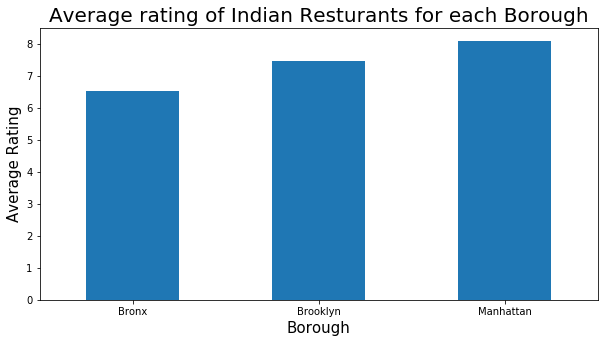

In [30]:
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5))
plt.title('Average rating of Indian Resturants for each Borough', fontsize=20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

### List of neighborhoods with average rating of >=8 for Indian cuisine

In [51]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [52]:
ny_neighborhood_stats

,Neighborhood,Average Rating
3,Central Harlem,8.000
4,Clinton Hill,8.800
6,Downtown,8.000
7,East Flatbush,8.300
10,Fort Greene,8.800
12,Gramercy,8.475
19,Murray Hill,8.600
20,Ocean Hill,8.000
22,Prospect Heights,8.700
23,Prospect Lefferts Gardens,8.700


In [53]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df_ny, on='Neighborhood')

In [54]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

### Mapping the restaurants for better visualtisation using folium map

In [55]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [56]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='#EA1253',
            fill=True,
            fill_color='#12EA92',
            fill_opacity=0.4
        )
    )

In [57]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [58]:

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)